<a href="https://colab.research.google.com/github/ReynaldiJ/portfolio/blob/main/Image_Pattern_Matching_using_SIFT%2C_AKAZE%2C_and_ORB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 as cv

In [ ]:
import zipfile

# Extracting from zipped file
zip_file_path = '/content/Dataset.zip'  # Replace with the path to your zip file
extract_folder = 'assets'
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [ ]:
# Dataset Description
asset_path = "/content/assets/Dataset/Data"
asset_list = [os.path.join(asset_path, img) for img in os.listdir(asset_path)]

target_img = cv.imread("/content/assets/Dataset/Target.jpg")

In [ ]:
def preprocess_image(img_path):
    img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_img = clahe.apply(img)
    return equalized_img

# Preprocess target image
target_img = preprocess_image("/content/assets/Dataset/Target.jpg")

# Preprocess all images in dataset
preprocessed_images = [preprocess_image(img) for img in asset_list]

In [ ]:
sift = cv.SIFT_create()
kp_target, des_target = sift.detectAndCompute(target_img, None)
dataset_features = [(img, sift.detectAndCompute(img, None)) for img in preprocessed_images]

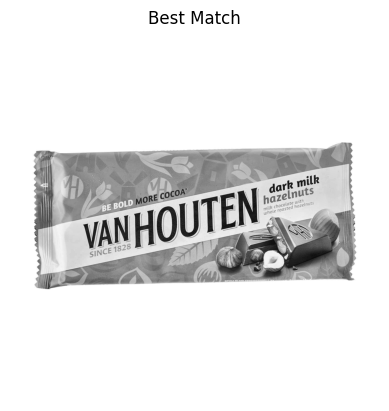

In [ ]:
bf = cv.BFMatcher()

best_match = None
best_score = float('inf')

for img, (kp, des) in dataset_features:
    matches = bf.knnMatch(des_target, des, k=2)
    # Apply Lowe's ratio test
    good_matches = [m for m, n in matches if m.distance < 0.75 * n.distance]

    if len(good_matches) < best_score:
        best_match = img
        best_score = len(good_matches)

# Display the best match
import matplotlib.pyplot as plt

if best_match is not None:
    plt.imshow(best_match, cmap='gray')  # Adjust the color map if necessary
    plt.title("Best Match")
    plt.axis('off')
    plt.show()
else:
    print("No best match found.")


##SIFT

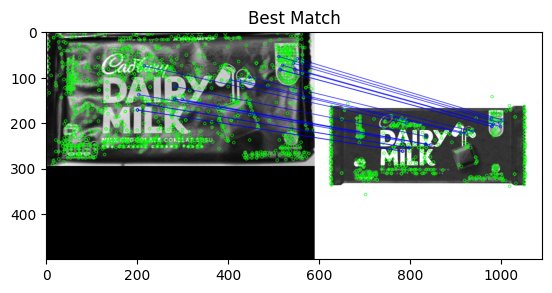

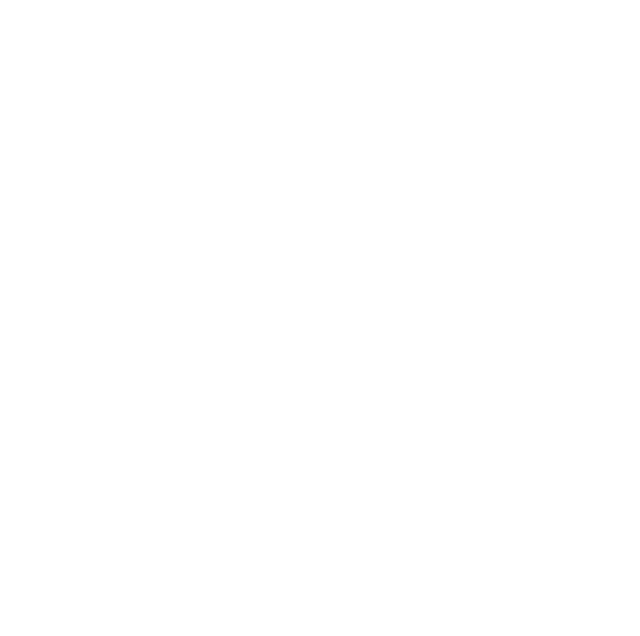

In [ ]:
SIFT = cv.SIFT_create()
SIFT_keypoint, SIFT_descriptor = SIFT.detectAndCompute(target_img, None)
SIFT_descriptor = np.float32(SIFT_descriptor)

flann = cv.FlannBasedMatcher(dict(algorithm = 1), dict(check = 50))

def createMask(mask, match):
  for i, (f, s) in enumerate(match):
    if f.distance < 0.5*s.distance:
      mask[i] = [1, 0]
  return mask

best_match = [0, None, None, None, None, None]

for path in asset_list:
  view = cv.imread(path)
  view = cv.cvtColor(view, cv.COLOR_BGR2GRAY)

  view = cv.medianBlur(view, 3)

  view_keypoint, view_descriptor = SIFT.detectAndCompute(view, None)
  view_descriptor = np.float32(view_descriptor)

  sift_match = flann.knnMatch(SIFT_descriptor, view_descriptor, 2)

  sift_mask = [[0, 0] for i in range (0, len(sift_match))]
  sift_mask = createMask(sift_mask, sift_match)

  if (np.sum(sift_mask) > best_match[0]):
    best_match[0] = np.sum(sift_mask)
    best_match[1] = view
    best_match[2] = view_keypoint
    best_match[3] = view_descriptor
    best_match[4] = sift_mask
    best_match[5] = sift_match

result = cv.drawMatchesKnn(target_img, SIFT_keypoint,
                            best_match[1], best_match[2],
                            best_match[5], None,
                            matchColor = [255, 0, 0],
                            singlePointColor= [0, 255, 0],
                            matchesMask = best_match[4])

result = cv.cvtColor(result, cv.COLOR_BGR2RGB)

plt.imshow(result)
plt.title("Best Match")
plt.figure(figsize=(8,8))
plt.axis('off')
plt.show()

##AKAZE

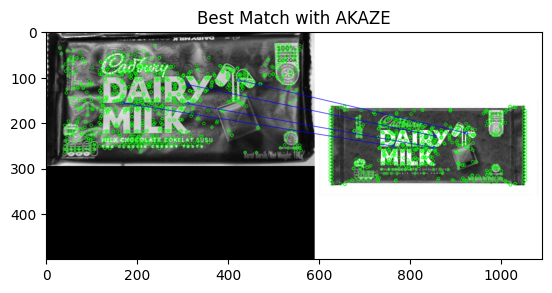

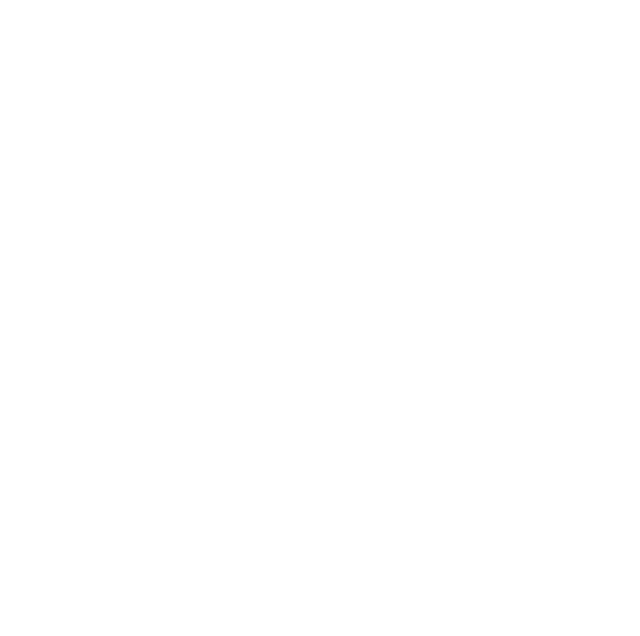

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing function: Grayscale + Adaptive Histogram Equalization
def preprocess_image(img):
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized_img = clahe.apply(gray)
    return equalized_img

# Initialize AKAZE
akaze = cv.AKAZE_create()

# Detect keypoints and descriptors in the target image
AKAZE_keypoint, AKAZE_descriptor = akaze.detectAndCompute(target_img, None)

# Initialize FLANN matcher for AKAZE
flann = cv.FlannBasedMatcher(dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=1), dict(checks=50))

# Create mask function based on Lowe's ratio test
def createMask(mask, match):
    for i, m in enumerate(match):
        # Ensure there are at least 2 matches
        if len(m) == 2:
            f, s = m
            if f.distance < 0.5 * s.distance:
                mask[i] = [1, 0]
    return mask

best_match = [0, None, None, None, None, None]

for path in asset_list:
    view = cv.imread(path)

    # Preprocess the image (Grayscale + Adaptive Histogram Equalization)
    view_preprocessed = preprocess_image(view)

    # Apply median blur after preprocessing
    view_preprocessed = cv.medianBlur(view_preprocessed, 3)

    # Detect keypoints and descriptors in the preprocessed image using AKAZE
    view_keypoint, view_descriptor = akaze.detectAndCompute(view_preprocessed, None)

    # Find matches using FLANN-based matcher
    akaze_match = flann.knnMatch(AKAZE_descriptor, view_descriptor, 2)

    # Create mask based on Lowe's ratio test
    akaze_mask = [[0, 0] for _ in range(len(akaze_match))]
    akaze_mask = createMask(akaze_mask, akaze_match)

    # Update the best match based on the mask sum
    if np.sum(akaze_mask) > best_match[0]:
        best_match[0] = np.sum(akaze_mask)
        best_match[1] = view_preprocessed
        best_match[2] = view_keypoint
        best_match[3] = view_descriptor
        best_match[4] = akaze_mask
        best_match[5] = akaze_match

# Draw matches between the target image and the best match
result = cv.drawMatchesKnn(target_img, AKAZE_keypoint,
                            best_match[1], best_match[2],
                            best_match[5], None,
                            matchColor=[255, 0, 0],
                            singlePointColor=[0, 255, 0],
                            matchesMask=best_match[4])

# Convert result to RGB for plotting
result = cv.cvtColor(result, cv.COLOR_BGR2RGB)

# Display the result
plt.imshow(result)
plt.title("Best Match with AKAZE")
plt.figure(figsize=(8,8))
plt.axis('off')
plt.show()


##ORB

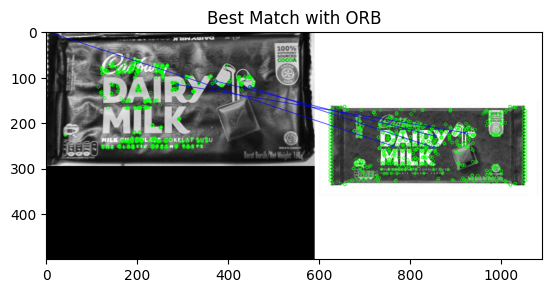

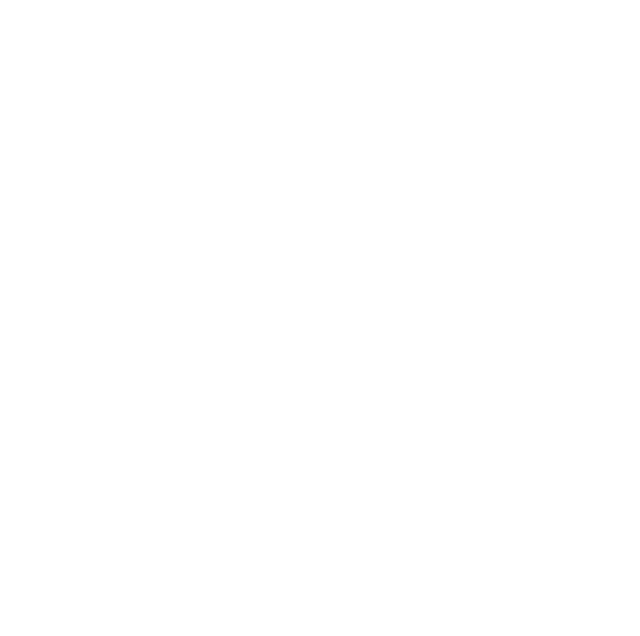

In [ ]:
for path in asset_list:
    view = cv.imread(path)

    if view is None:
        print(f"Error: Could not load image at path {path}")
        continue

    view_preprocessed = preprocess_image(view)
    view_preprocessed = cv.medianBlur(view_preprocessed, 3)

    view_keypoint, view_descriptor = orb.detectAndCompute(view_preprocessed, None)

    if view_descriptor is None:
        print(f"Error: No descriptors found for image {path}")
        continue

    orb_match = bf.knnMatch(ORB_descriptor, view_descriptor, k=2)

    orb_mask = [[0, 0] for _ in range(len(orb_match))]
    orb_mask = createMask(orb_mask, orb_match)

    if np.sum(orb_mask) > best_match[0]:
        best_match[0] = np.sum(orb_mask)
        best_match[1] = view_preprocessed
        best_match[2] = view_keypoint
        best_match[3] = view_descriptor
        best_match[4] = orb_mask
        best_match[5] = orb_match

if best_match[1] is not None:
    result = cv.drawMatchesKnn(target_img, ORB_keypoint,
                               best_match[1], best_match[2],
                               best_match[5], None,
                               matchColor=[255, 0, 0],
                               singlePointColor=[0, 255, 0],
                               matchesMask=best_match[4])

    result = cv.cvtColor(result, cv.COLOR_BGR2RGB)
    plt.imshow(result)
    plt.title("Best Match with ORB")
    plt.figure(figsize=(8,8))
    plt.axis('off')
    plt.show()
else:
    print("Error: No best match found.")
